In [1]:
import json
import os
import psycopg2
import pandas as pd
import sqlalchemy
import sys
sys.path.append("..")

from connect_db import db_connection


import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

username='ywang99587'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



from scipy.spatial import distance
import scipy.spatial.distance
from scipy.spatial.distance import cdist, pdist
import pylab as pl

In [ ]:
import sys

r_path = "../new_codebase/src/utils/load_data/"
sys.path.append(r_path)
from load_dataframes import *

season='winter'
country='Japan'
df=get_k_means_data(username,season, country).replace(np.nan,0)

In [ ]:
df.describe()

In [8]:
df_feature_all = df

In [9]:
df_feature_all.shape

(255229, 51)

In [10]:
df_feature_all.columns

Index(['mcc', 'hr_arvl_tusc', 'day_of_wk_arvl_tusc', 'mon_arvl_tusc',
       'day_arvl_tusc', 'loc_arvl_tusc', 'hr_arvl_italy',
       'day_of_wk_arvl_italy', 'mon_arvl_italy', 'day_arvl_italy',
       'loc_arvl_italy', 'locs_outside_tuscany', 'unique_locs_outside_tuscany',
       'customer_nr', 'start_lat', 'start_lon', 'end_lat', 'end_lon',
       'hrs_in_italy', 'hrs_in_tusc', 'avg_lat', 'avg_lon', 'top_lat',
       'top_lon', 'std_lat', 'std_lon', 'hrs_outside_tuscany',
       'start_lat_tusc', 'start_lon_tusc', 'num_unique_loc_in_tusc',
       'num_loc_in_tusc', 'num_unique_loc_in_italy', 'num_loc_in_italy',
       'st_time', 'en_time', 'total_time', 'forest', 'water', 'river', 'park',
       'arezzo', 'florence', 'grosseto', 'livorno', 'lucca', 'pisa', 'pistoia',
       'siena', 'coast', 'num_attrs', 'country'],
      dtype='object')

In [11]:
def select_scale_features(df_feature_all, hrs=True, numlocs=True, location=True, latlon=True):
    """
    Select relevant features and perform feature scaling
    Returns DataFrame with selected and scaled features, and customers who did not move removed for k-means clustering
    Parameters:
    df_feature_all: DataFrame containing all features from the feature table
    hrs: Feature group that contains hours spent in Tuscany, hours spent outside Tuscany
    numlocs: Feature group that contains number of locations and number of unique locations visited in Tuscany and Italy
    location: Feature group that contains time spent (in mumtiples of ) at the locations with respective features, 
    including landscape, cities visited, and total number of attactions visited.
    """

    feat_hrs = ['hrs_in_tusc', 'hrs_outside_tuscany']
    feat_numlocs = ['num_loc_in_tusc','num_unique_loc_in_tusc','num_loc_in_italy','num_unique_loc_in_italy']
    feat_location = ['forest', 'water', 'river', 'park', 'arezzo', 'florence', 'livorno',
       'lucca', 'pisa', 'pistoia', 'siena', 'coast', 'num_attrs']
    feat_latlon = ['avg_lat', 'avg_lon', 'top_lat','top_lon','start_lat_tusc', 'start_lon_tusc',
              'start_lat', 'start_lon', 'end_lat', 'end_lon', 'std_lat', 'std_lon']

    feat_groups = [feat_hrs, feat_numlocs, feat_location, feat_latlon] # latlon always in the end
    args = [hrs, numlocs, location, latlon]
    feat_list = []    
    for i in range(0, (len(feat_groups)-1)):
        if args[i]==True:
            feat_list.extend(feat_groups[i])  
    # Separate condition for latlon to not append last two columns (std_lat, std_lon not to be scaled)
    if args[len(args)-1]==True:    
        feat_list.extend(feat_groups[len(args)-1][0:(len(feat_latlon)-2)]) 

    df_feature_cont = df_feature_all[feat_list]
    scaler = StandardScaler()
    scaled_feature_all = pd.DataFrame(scaler.fit_transform(df_feature_cont), columns = df_feature_cont.columns)
    df_scaled = pd.concat([scaled_feature_all.reset_index(drop=True), df_feature_all[['std_lat', 'std_lon']]], axis=1)
    # Remove rows with std_lat (customer who did not move)
    df_kmeans = df_scaled[df_scaled['std_lat']>0]
    return df_kmeans

In [12]:
def kmeans_model(df_kmeans, nc=5):
    """
    Returns scaled features DataFrame with labels based on k-means
    Parameters:
    df_kmeans: DataFrame returned from select_scale_features
    """
    kmeans = KMeans(n_clusters=nc, n_jobs=-1)
    kmeans.fit(df_kmeans)
    labels = kmeans.labels_
    df_kmeans_labeled = df_kmeans
    df_kmeans_labeled['label'] = labels
    return df_kmeans_labeled

In [13]:
def raw_labeled_features(df_feature_all, df_kmeans_labeled):
    """
    Returns DataFrame with unscaled features with labels based on k-means
    Parameters:
    df_feature_all: DataFrame containing all unscaled features from the feature table
    df_kmeans_labeled: DataFrame returned from kmeans_models to select columns and add label
    """
    df_feature_moving = df_feature_all[df_feature_all['std_lat']>0]
    df_feature_moving['label'] = df_kmeans_labeled['label']
    df_feature_raw_labeled = df_feature_moving[df_kmeans_labeled.columns]    
    return df_feature_raw_labeled

In [14]:
def clusters_info(df_kmeans_labeled):
    """
    Returns cluster information: label, size of cluster, ratio of whole group of customers, ordered by size of cluster
    Parameters:
    df_kmeans_labeled: DataFrame returned from kmeans_model containing scaled features DataFrame with labels based on k-means
    """
    nc = len(df_kmeans_labeled.label.unique())
    ls_cluster_info = []
    for i in range(0, nc):
        cluster = df_kmeans_labeled[df_kmeans_labeled['label']==i]
        cluster_len = len(cluster)
        cluster_ratio = cluster_len/len(df_kmeans_labeled)*100
        cluster_info = pd.DataFrame([i, cluster_len, cluster_ratio]).T
        ls_cluster_info.append(cluster_info)
    df_cluster_info = pd.concat(ls_cluster_info)
    df_cluster_info.columns = ['label', 'length', 'ratio']
    df_cluster_info = df_cluster_info.sort_values(by='length', ascending=False)
   # df_cluster_info_sub = df_cluster_info.iloc[0:3]
    return(df_cluster_info)

In [20]:
#from geopandas import GeoDataFrame
#from shapely.geometry import Point



r_path_shp = "../new_codebase/src/utils/read_shapefiles/"
json_file = 'shape_files_path.json'
sys.path.append(r_path_shp)
from read_files import read_shapefile_data, read_shapefiles_in

r_path_viz = "../new_codebase/viz"
sys.path.append(r_path_viz)
from maps import Map




def plot_cluster(df_feature_raw_labeled, df_cluster_info, write=False, path="", outfile=""):
    """
    Plot top three clusters by size on the map of Tuscany at the territory level 
    """
    df_latlon_labeled = df_feature_raw_labeled[['avg_lat', 'avg_lon', 'top_lat', 'top_lon', 'label']]
    # shapefile of territories in Tuscany
    path_shapefiles, regions, provinces, territories, municipalities, crs = read_shapefile_data(r_path_shp,json_file)
    df_ter_tus = read_shapefiles_in(True, path_shapefiles, territories, crs, apply_crs=False)
    basemap = Map(df_ter_tus)
    basemap.plot()
    basemap.important_cities()

    # plot three largest clusters
    colors = ['go', 'ro', 'bo']
    for i in range(0, 3):
        
        cn = df_cluster_info.index.values.astype(int)[i]
        cluster = df_feature_raw_labeled[df_feature_raw_labeled['label']==cn]
        basemap.ax.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], colors[i], markersize=0.9, alpha=0.1)
        
    plt.ylim([42.3, 44.5])
    plt.xlim([9.5, 12.5])
    plt.show()
    
    if write==True:
        plt.savefig(path+outfile)
    

In [45]:

r_path_data = "../new_codebase/src/models/kmeans/"
sys.path.append(r_path_data)
from kmeans import *

result = get_cluster_results('ywang99587','summer', 'hungary', features, nc=4)
df_cluster_info = calculate_cluster_size(result)

   label  ratio
4  16438  49.72
0  10243  30.98
3   3631  10.98
2   2751   8.32
1      1   0.00


In [49]:
result.shape

(33543, 51)

In [50]:
clusters=[]
clen=0
for i in range(0,5):
    cluster=result[result['label']==i]
    clusters.append(cluster)
    clen+=len(cluster)
    print(clusters[i].shape)
print(clen)

(10243, 51)
(1, 51)
(2751, 51)
(3631, 51)
(16438, 51)
33064


In [ ]:
airport_cities = {"Pisa": [43.7228, 10.4017], 
         "Florence": [43.7696, 11.2558]}

In [6]:
airport_cities_d = {"airport": ['Pisa', 'Florence'], 
         "lat": [43.7228, 43.7696], "lon": [10.4017, 11.2558]}

In [38]:
airport_cities_d = {"airport": ['Pisa', 'Florence'], ## airport coords
         "lat": [43.683889, 43.81], "lon": [10.3925, 11.203889]}

In [39]:
airport_cities = pd.DataFrame(airport_cities_d)
airport_cities

,airport,lat,lon
0,Pisa,43.683889,10.392500
1,Florence,43.810000,11.203889


In [40]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt ## this is a different name from atop??

geometry = [Point(xy) for xy in zip(airport_cities.lon, airport_cities.lat)]
airport_cities = airport_cities.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_airport_cities = GeoDataFrame(airport_cities, crs=crs, geometry=geometry)
geo_airport_cities.head()

,airport,geometry
0,Pisa,POINT (10.3925 43.683889)
1,Florence,POINT (11.203889 43.81)


In [41]:
geo_airport_cities.crs

{'init': 'epsg:4326'}

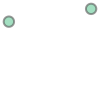

In [42]:
buffer = geo_airport_cities['geometry'].unary_union.buffer(.051)
buffer

In [8]:
type(buffer)

shapely.geometry.polygon.Polygon

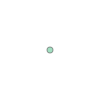

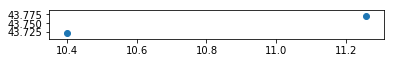

In [9]:
geo_airport_cities.plot()
geo_airport_cities['geometry'].loc[0]

In [10]:
pisa = geo_airport_cities['geometry'].loc[0]

In [34]:
point1_d = {"lat":[43.7],"lon":[10.4]}

In [35]:
point1 = pd.DataFrame(point1_d)
point1

,lat,lon
0,43.7,10.4


In [36]:
geometry = [Point(zip(point1.lon, point1.lat))]

In [37]:
geo_point1 = GeoDataFrame(point1.drop(['lon', 'lat'], axis=1), crs=crs, geometry=geometry)
geo_point1.head()

,geometry
0,POINT (10.4 43.7)


In [39]:
geo_point1.within(geo_airport_cities['geometry'].loc[0].buffer(.1))

0    True
dtype: bool

In [51]:
def near_airport(row):
    #airport_cities_d = {"airport": ['Pisa', 'Florence'], 
    #     "lat": [43.7228, 43.7696], "lon": [10.4017, 11.2558]}
    airport_cities_d = {"airport": ['Pisa', 'Florence'], ## airport coords
         "lat": [43.683889, 43.81], "lon": [10.3925, 11.203889]}
    airport_cities = pd.DataFrame(airport_cities_d)
    geometry = [Point(xy) for xy in zip(airport_cities.lon, airport_cities.lat)]
    airport_cities = airport_cities.drop(['lon', 'lat'], axis=1)
    crs = {'init': 'epsg:4326'}
    geo_airport_cities = GeoDataFrame(airport_cities, crs=crs, geometry=geometry)
    if ((row.within(geo_airport_cities['geometry'].unary_union.buffer(0.051)))):
        return 1
    else:
        return 0

In [52]:
cluster = result[result['label']==2]
geometry_st = [Point(xy) for xy in zip(cluster.start_lon, cluster.start_lat)]
geometry_end = [Point(xy) for xy in zip(cluster.end_lon, cluster.end_lat)]
cluster_pt_st = cluster.drop(['start_lon', 'start_lat'], axis=1)
cluster_pt_end = cluster.drop(['end_lon', 'end_lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_st = GeoDataFrame(cluster_pt_st, crs=crs, geometry=geometry_st)
geo_end = GeoDataFrame(cluster_pt_end, crs=crs, geometry=geometry_end)
cluster['start_airport'] = geo_st['geometry'].apply(near_airport,1)
cluster['end_airport'] = geo_end['geometry'].apply(near_airport,1)
cluster.start_airport.sum()/len(cluster)*100
cluster.end_airport.sum()/len(cluster)*100
print(cluster.start_airport.sum()/len(cluster)*100)
print(cluster.end_airport.sum()/len(cluster)*100)
cluster.head()

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5.8160668847691745
6.106870229007633


/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mcc,hr_arvl_tusc,day_of_wk_arvl_tusc,mon_arvl_tusc,day_arvl_tusc,loc_arvl_tusc,hr_arvl_italy,day_of_wk_arvl_italy,mon_arvl_italy,day_arvl_italy,...,lucca,pisa,pistoia,siena,coast,num_attrs,country,label,start_airport,end_airport
customer_nr,,,,,,,,,,,,,,,,,,,,,
451143.0,216.0,19.0,6.0,6.0,3.0,3661632.0,0.0,6.0,6.0,3.0,...,27.0,152.0,0.0,80.0,0.0,0.0,Hungary,2.0,0,0
5283396.0,216.0,15.0,5.0,6.0,2.0,16934013.0,9.0,5.0,6.0,2.0,...,0.0,0.0,0.0,31.0,997.0,0.0,Hungary,2.0,0,0
5281829.0,216.0,12.0,6.0,6.0,3.0,3032201.0,7.0,6.0,6.0,3.0,...,0.0,90.0,0.0,32.0,0.0,0.0,Hungary,2.0,0,0
407707.0,216.0,15.0,4.0,6.0,1.0,3631302.0,12.0,4.0,6.0,1.0,...,122.0,954.0,0.0,1069.0,0.0,1.0,Hungary,2.0,0,0
462773.0,216.0,19.0,0.0,6.0,4.0,57340012.0,13.0,0.0,6.0,4.0,...,96.0,269.0,0.0,244.0,89.0,0.0,Hungary,2.0,0,0


In [29]:
cluster.start_airport.sum()/len(cluster)*100


21.63848997152033

In [30]:
cluster.end_airport.sum()/len(cluster)*100

18.82082045688663

In [ ]:
# spatial points of start lat/lon
for cluster in clusters:
    geometry_st = [Point(xy) for xy in zip(cluster.start_lon, cluster.start_lat)]
    geometry_end = [Point(xy) for xy in zip(cluster.end_lon, cluster.end_lat)]
    cluster_pt_st = cluster.drop(['start_lon', 'start_lat'], axis=1)
    cluster_pt_end = cluster.drop(['end_lon', 'end_lat'], axis=1)
    crs = {'init': 'epsg:4326'}
    geo_st = GeoDataFrame(cluster_pt_st, crs=crs, geometry=geometry_st)
    geo_end = GeoDataFrame(cluster_pt_end, crs=crs, geometry=geometry_end)
    cluster['start_airport'] = geo_start['geometry'].apply()

In [ ]:
# spatial points of start lat/lon
for cluster in clusters:
    geometry_st = [Point(xy) for xy in zip(cluster.start_lon, cluster.start_lat)]
    geometry_end = [Point(xy) for xy in zip(cluster.end_lon, cluster.end_lat)]
    cluster_pt_st = cluster.drop(['start_lon', 'start_lat'], axis=1)
    cluster_pt_end = cluster.drop(['end_lon', 'end_lat'], axis=1)
    crs = {'init': 'epsg:4326'}
    geo_st = GeoDataFrame(cluster_pt_st, crs=crs, geometry=geometry_st)
    geo_end = GeoDataFrame(cluster_pt_end, crs=crs, geometry=geometry_end)

In [80]:
top_start_locs = []
top_start_ratio = []
for cluster in clusters:
    cluster['start_lat2'] = cluster.start_lat.round(2)
    cluster['start_lon2'] = cluster.start_lon.round(2)
    latlon_count = pd.DataFrame(cluster.groupby(['start_lat2','start_lon2']).count()['mcc'])
    latlon_count = latlon_count.rename(columns={'mcc':'count'})
    latlon_count = latlon_count.sort_values('count', ascending=False)
    print(latlon_count.head())
   # cluster_loc = cluster_loc.sort_values('mcc', ascending=False)
   # print(cluster_loc.head())
    #top_start_locs.append()
    #top_start_locs.append(pd.Series(cluster_loc.iloc[0].name))
    #top_start_ratio.append(cluster_loc.iloc[0,1]/len(cluster))

                       count
start_lat2 start_lon2       
46.52      13.61          21
43.56      10.31          18
43.70      10.40          17
45.82      13.14          12
43.55      10.30          11
                       count
start_lat2 start_lon2       
45.82      13.14         613
46.52      13.61         585
45.83      13.10         274
45.70      13.80         233
           13.83         189
                       count
start_lat2 start_lon2       
46.52      13.61         162
45.82      13.14         150
45.83      13.10          87
45.70      13.80          68
43.95      11.22          55
                       count
start_lat2 start_lon2       
46.52      13.61         197
45.82      13.14          94
45.69      13.79          84
45.83      13.10          83
43.70      10.40          80
                       count
start_lat2 start_lon2       
43.77      11.25         539
43.70      10.40         483
43.77      11.26         457
43.78      11.25         398
43.95      11.

In [13]:
df_top_start = pd.concat(top_start_locs, axis=1)
df_top_start

,0,1,2,3,4
0,46.52,46.52,43.77,45.82,43.54
1,13.61,13.61,11.25,13.14,11.22


In [15]:
top_end_locs = []
top_end_ratio = []
for cluster in clusters:
    cluster['end_lat2'] = cluster.end_lat.round(2)
    cluster['end_lon2'] = cluster.end_lon.round(2)
    cluster_loc = pd.DataFrame(cluster.groupby(['end_lat2','end_lon2']).count())
    cluster_loc = cluster_loc.sort_values('mcc',ascending=False)
    top_end_locs.append(pd.Series(cluster_loc.iloc[0].name))
    top_end_ratio.append(cluster_loc.iloc[0,1]/len(cluster))

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_top_end = pd.concat(top_end_locs, axis=1)
df_top_end

,0,1,2,3,4
0,45.70,45.70,43.7,45.82,43.99
1,13.83,13.83,10.4,13.14,11.21


In [15]:
df_cluster_info.index.values.astype(int)[0]

0

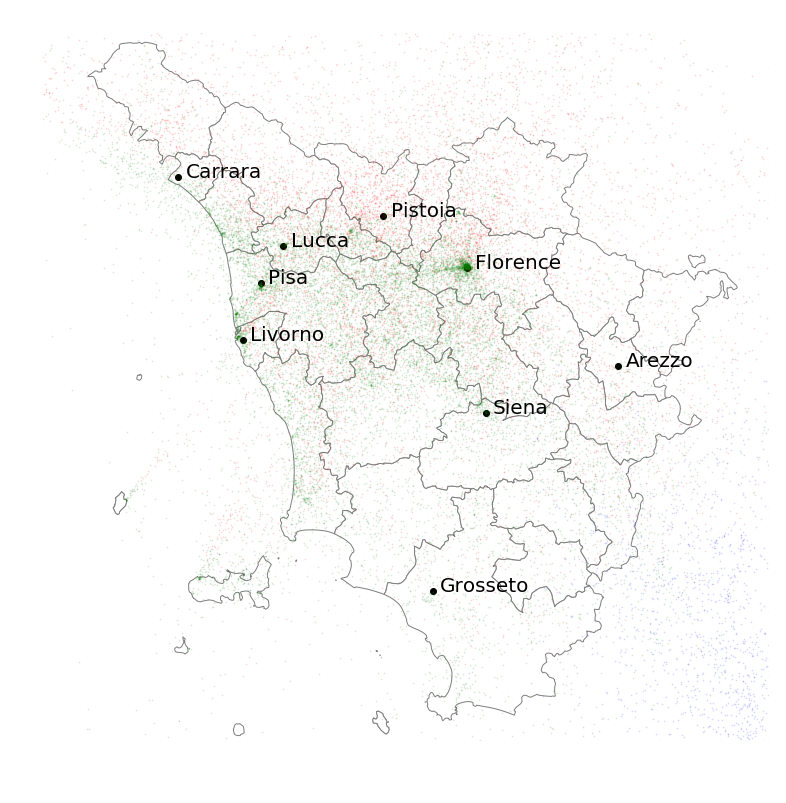

In [21]:
plot_cluster(result, df_cluster_info)

In [16]:
aa = select_scale_features(df_feature_all, hrs=False,location=True)
aa.head()

,num_loc_in_tusc,num_unique_loc_in_tusc,num_loc_in_italy,num_unique_loc_in_italy,forest,water,river,park,arezzo,florence,...,top_lat,top_lon,start_lat_tusc,start_lon_tusc,start_lat,start_lon,end_lat,end_lon,std_lat,std_lon
0,-0.546420,-0.800014,-0.636136,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.287650,-0.017163,0.433557,0.038107,0.229931,-0.115506,0.304293,-0.142675,0.002309,0.000173
4,-0.543995,-0.784593,-0.634157,-0.837090,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.345108,-0.058461,0.517242,-0.018301,0.267610,-0.145636,0.278426,-0.160990,0.020200,0.081550
9,-0.543995,-0.800014,-0.634157,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.352032,0.088401,0.527326,0.182296,0.272150,-0.038488,0.347677,-0.068055,0.066750,0.024150
12,-0.546420,-0.800014,-0.636136,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.279632,0.010671,0.421880,0.076124,0.224674,-0.095199,0.298890,-0.123000,0.001848,0.005196
13,-0.536721,-0.784593,-0.628218,-0.837090,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.302227,0.001846,0.454788,0.064070,0.239490,-0.101638,0.305439,-0.174666,0.004006,0.021468


In [17]:
bb = kmeans_model(aa)
bb.head()

,num_loc_in_tusc,num_unique_loc_in_tusc,num_loc_in_italy,num_unique_loc_in_italy,forest,water,river,park,arezzo,florence,...,top_lon,start_lat_tusc,start_lon_tusc,start_lat,start_lon,end_lat,end_lon,std_lat,std_lon,label
0,-0.546420,-0.800014,-0.636136,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,-0.017163,0.433557,0.038107,0.229931,-0.115506,0.304293,-0.142675,0.002309,0.000173,0
4,-0.543995,-0.784593,-0.634157,-0.837090,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,-0.058461,0.517242,-0.018301,0.267610,-0.145636,0.278426,-0.160990,0.020200,0.081550,0
9,-0.543995,-0.800014,-0.634157,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.088401,0.527326,0.182296,0.272150,-0.038488,0.347677,-0.068055,0.066750,0.024150,0
12,-0.546420,-0.800014,-0.636136,-0.846201,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.010671,0.421880,0.076124,0.224674,-0.095199,0.298890,-0.123000,0.001848,0.005196,0
13,-0.536721,-0.784593,-0.628218,-0.837090,-0.032528,-0.017039,-0.070281,-0.038395,-0.073576,-0.53976,...,0.001846,0.454788,0.064070,0.239490,-0.101638,0.305439,-0.174666,0.004006,0.021468,0


In [18]:
cc = raw_labeled_features(df_feature_all, bb)
cc.head()

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,num_loc_in_tusc,num_unique_loc_in_tusc,num_loc_in_italy,num_unique_loc_in_italy,forest,water,river,park,arezzo,florence,...,top_lon,start_lat_tusc,start_lon_tusc,start_lat,start_lon,end_lat,end_lon,std_lat,std_lon,label
0,4,2,4,2,0,0,0,0,0,0,...,11.247800,43.7766,11.2478,43.776600,11.247800,43.776600,11.247800,0.002309,0.000173,0
4,5,3,5,3,0,0,0,0,0,0,...,11.211300,43.8239,11.2113,43.823900,11.211300,43.745000,11.224900,0.020200,0.081550,0
9,5,2,5,2,0,0,0,0,0,0,...,11.341100,43.8296,11.3411,43.829600,11.341100,43.829600,11.341100,0.066750,0.024150,0
12,4,2,4,2,0,0,0,0,0,0,...,11.272400,43.7700,11.2724,43.770000,11.272400,43.770000,11.272400,0.001848,0.005196,0
13,8,3,8,3,0,0,0,0,0,0,...,11.264600,43.7886,11.2646,43.788600,11.264600,43.778000,11.207800,0.004006,0.021468,0


In [19]:
dd = clusters_info(df_kmeans_labeled=bb)
print(dd)

   label    length      ratio
0    0.0  137582.0  57.641662
0    3.0   40580.0  17.001487
0    1.0   31223.0  13.081258
0    2.0   27510.0  11.525651
0    4.0    1790.0   0.749942


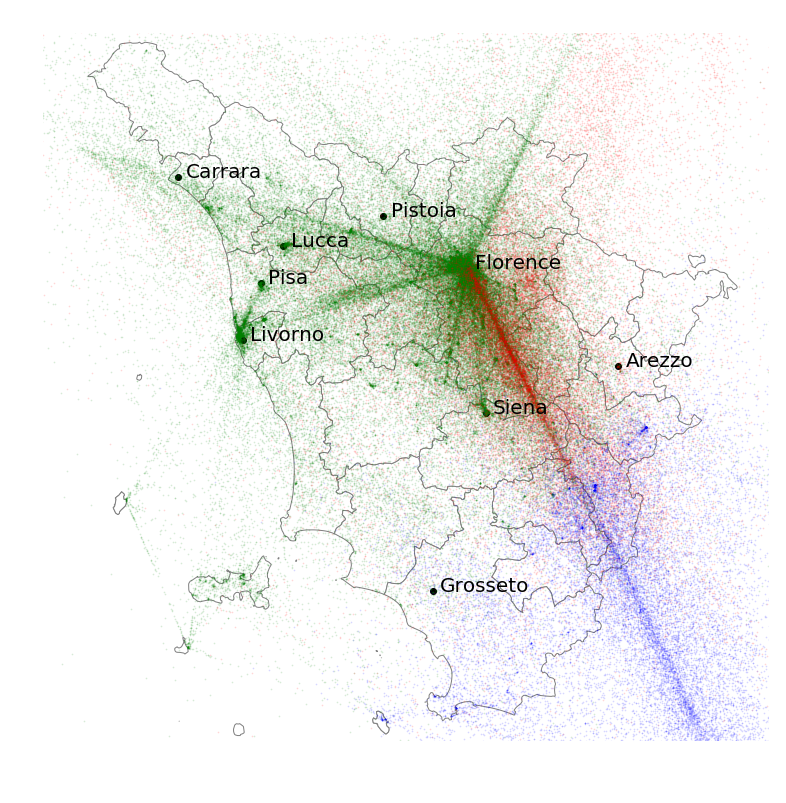

In [20]:
plot_cluster(df_feature_raw_labeled=cc, df_cluster_info=dd)